# Functions

**Generate the B graph**

In [9]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import random
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from numpy.ma.extras import average
from sklearn.metrics import confusion_matrix
import csv

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcdefaults()

### Data Generation Functions

In [3]:
def B_mat_symmetric(a, p):
    '''To generate a symmetric toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/super-diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
        np.fill_diagonal(result[:,i:], -1*a[i]) # Super-diagonals
    return result


def B_mat_lowertriangular(a, p):
    '''To generate a lower triangular toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
    return result


def cov_x(p):
    """ Generate the covariance matrix for x"""
    sigma_x = np.eye(p)
    return sigma_x


def cov_y(sigma_x, B):
    """ Generate covariance matrix for Y i.e. (B^(-1).X.B^(-T)) since Y=B^(-1).X"""
    B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
    sigma_y = B_inv@sigma_x@B_inv.T
    return sigma_y


def generate_y(mean_y, sigma_y, n_samples):
    """ Generate samples of Y"""
    y_samples = multivariate_normal.rvs(mean=mean_y, cov=sigma_y, size=n_samples)
    return y_samples
    
    
def samp_cov(y_samples):
    """ Generating sample covariance matrix """
    n_samples = len(y_samples)
    samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    return samp_cov_y


def soft(x, y):
    return np.sign(x) * np.maximum(np.abs(x) - y, 0)


def threshold(vec, threshold_value=0.002):
    vec1 = vec.copy()
    vec1[np.abs(vec) < threshold_value] = 0
    return vec1


def binarize_matrix(matrix):
    '''Converts non-zero elements to 1 and keeps zeros as zeros.'''
    binary_matrix = np.where(matrix != 0, 1, 0)
    return binary_matrix


def compute_recovery_rate_numpy(a_binary, true_a_binary):
    joint_ones = np.sum((a_binary == 1) & (true_a_binary == 1)) # True positives + False positives
    ones_true_a = np.sum(true_a_binary == 1) # True positives
    if ones_true_a == 0:
        return 0
    return joint_ones / ones_true_a


def create_sparse_vec_pos_def_2(dim, nonzeros, diag=20):
    ''' Function to create sparse vector(p x 1) which can generate symmetric +ve definite toeplitz matrix'''
    vec = np.zeros((dim,))
    vec[0] = diag
    nonzeros -= 1
    # selection of indicies with the non-zero entry (random selection)
    non_zero_indices = random.sample(range(1,dim),nonzeros)
    for idx in non_zero_indices:
        # Randomly assign values to non-zero entries 
        vec[idx] = random.randint(1,5)
    return vec


### Different functions for ADMM ###

def f1(a, S, sigma_x, rho, a2, mu1, regularized = False):
    """ Function evaluation for Newton method with regularization term based on ADMM
       TODO: verify this Tr[S.Theta_y] - logdet(Theta_y) + rho/2*||a1 - a2 + mu1||_1"""
    p = S.shape[0]
    a.reshape((-1,))
    B = B_mat_symmetric(a, p)
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    if regularized:
        # Added [1:] since we don't want to regularize a0
        reg_term = (rho/2)*np.linalg.norm(a[1:]-a2+mu1)
    else:
        reg_term = 0
    return np.trace(S@B.T@theta_x@B)-np.log(np.linalg.det(B.T@theta_x@B))+reg_term 


def f2(a, lam):
    """ Function evaluation of regularization term """
    return lam*np.linalg.norm(a[1:],1)
    
    
def f(a, S, sigma_x):
    a.reshape((-1,))
    B = B_mat_symmetric(a, S.shape[0])
    sigma_x_inv = np.linalg.solve(sigma_x, np.eye(S.shape[0]))
    return np.trace(S@B.T@sigma_x_inv@B) - np.log(np.linalg.det(B.T@sigma_x_inv@B))

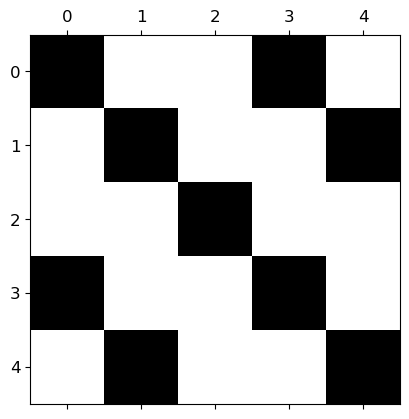

In [7]:
plt.spy(B_mat_symmetric([1,0,0,1,0],5))

In [4]:
def make_T_matrices(p, symmetric=False):
    """
    Returns a list [T0, T1, …, T(p-1)]
    """
    T_list = []
    I = np.eye(p)
    T_list.append(I)
    for j in range(1, p):
        M = np.zeros((p, p))
        # sub‑diagonal
        M[np.arange(j, p), np.arange(0, p-j)] = -1
        if symmetric:
            # super‑diagonal
            M[np.arange(0, p-j), np.arange(j, p)] = -1
        T_list.append(M)
    return T_list


Metrics

In [8]:
def kll(a, a_hat, sigma_x):
    ''' Computing the KL loss for the covariance matrices of Y'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return np.trace(sigma_y@theta_y_hat) - np.log(np.linalg.det(sigma_y@theta_y_hat)) - p

def rkll(a, a_hat, sigma_x):
    ''' Computing the reverse KL loss for the covariance matrices of Y'''
    return kll(a_hat, a, sigma_x)

def rte(a, a_hat, sigma_x):
    ''' Computing the relative trace error loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return abs(1 - (np.trace(theta_y_hat)/np.trace(theta_y)))

def norm_loss(a, a_hat, sigma_x):
    ''' Computing the norm loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    fro = np.linalg.norm(theta_y-theta_y_hat,ord='fro')
    spe = np.linalg.norm(theta_y-theta_y_hat,ord=2)
    l1 = np.linalg.norm(theta_y-theta_y_hat,ord=1)
    return fro, spe, l1

def scores(a, a_hat, threshold_value):
    ''' Computing the support recovery based scores for the precision matrix'''
    a_thr = threshold(a_hat, threshold_value=threshold_value) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    true_a_binary = binarize_matrix(a)  # True Support Vector
    cm = confusion_matrix(true_a_binary, a_binary)
    tn,fp,fn,tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    accuracy = (tn + tp)/np.sum(cm)
    specificity = (tn)/(tn + fp) # TN/(TN+FP)
    sensitivity = (tp)/(tp + fn) # TP/(TP+FN)
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, specificity, sensitivity, MCC, cm

### Gradient Computation

In [30]:
def grad_f(x, S, sigma_x, rho, a2, mu1, T_list, regularized = False):
    ''' Computing gradient for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0] # Dimensions
    B = B_mat_symmetric(x, p) # Generating B matrix with a given x
    # B = sum(x[j]*T_list[j] for j in range(p))
    B_inv = np.linalg.solve(B, np.eye(p))
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    if regularized:
        k = np.zeros_like(x)
        k[1:] = x[1:]-a2+mu1
    else:
        k = np.zeros_like(x)
    
    gradient = np.zeros((p,))
    for i in range(p):
            Ti = T_list[i] 
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti)) + (rho*k[i])
    return gradient


def hessian_f(x, S, sigma_x, rho,T_list, regularized = False):
    ''' Computing Hessian for f1(x) = Tr(S B(x) T B(x)) + log(det(B(x) T B(x)))
        both regularized and unregularized, where B is symmetric'''
    p = S.shape[0]
    B = B_mat_symmetric(x, p)
    # B = sum(x[j]*T_list[j] for j in range(p))
    B_inv = np.linalg.solve(B, np.eye(p))  
    # B_inv = np.linalg.solve(B, stack all Tis)  
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    
    hessian = np.zeros((p,p))
    for i in range(p):
        Ti = T_list[i]
        for j in range(p):
            Tj = T_list[j]
            hessian[i,j] = 2*(np.trace(S@Ti@theta_x@Tj) + np.trace(B_inv@Ti@B_inv@Tj))
    if regularized:
        reg = rho*np.eye(p)
        reg[0,0] = 0
        hessian+=reg
    return hessian

###  Newtons Method

In [31]:
def compute_newton_step(gradient, hessian):
    """
    Computes the Newton step and decrement.

    Parameters:
    gradient (np.array): Gradient vector.
    hessian (np.array): Hessian matrix.

    Returns:
    delta_x_nt (np.array): Newton step.
    lambd (float): Newton decrement.
    """
    delta_x_nt = -np.linalg.solve(hessian, gradient)  # Newton step
    lambd_sqr = np.dot(gradient.T, hessian@gradient)  # Newton decrement
    return delta_x_nt, lambd_sqr

def backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                             regularized=False, alpha=0.01, beta=0.5):
    """
    Backtracking line search to ensure sufficient decrease.

    Parameters:
    f (function): Function to minimize.
    gradient (np.array): Gradient vector.
    x (np.array): Current point.
    delta_x_nt (np.array): Newton step.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    t (float): Step size.
    """
    t = 1  # Start with full step size
    p = S.shape[0]
    x_ = x + t * delta_x_nt
    e_val, e_vec = np.linalg.eig(B_mat_symmetric(x_, p))
    i = 0
    while not np.all(e_val>0): 
        t *= beta # Reduce step size so that x + del_x is PSD
        x_ = x + t * delta_x_nt
        e_val, e_vec = np.linalg.eig(B_mat_symmetric(x_, p))
        i+=1
        if i>20:
            t = 0
            print('Backtracking line search (I) went beyond 20 iterations')
            break
    x_ = x + t * delta_x_nt
    i = 0
    while (f(x_,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           >f(x,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           + alpha*t*np.dot(gradient.T,delta_x_nt)):
        t *= beta  # Reduce step size
        x_ = x + t * delta_x_nt
        if (i>20) or (t==0):
            t = 0
            print('Backtracking line search (II) went beyond 20 iterations')
            break
    return t


def projection_Rp(x):
    y = np.maximum(x, np.zeros_like(x))
    return y


def newton_method(f, x0, S, sigma_x, rho, a2, mu1, T_list, epsilon=1e-6, alpha=0.01, beta=0.5,
                  regularized=False, backtracking=False, projection=False):
    """
    Implements Newton's method for optimization.

    Parameters:
    f (function): Function to minimize.
    grad_f (function): Gradient function.
    hessian_f (function): Hessian function.
    x0 (np.array): Initial point.
    epsilon (float): Stopping criterion for Newton decrement.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    x (np.array): Optimized point.
    """
    x = x0
    i = 0
    while True:
        gradient = grad_f(x, S, sigma_x, rho, a2, mu1, T_list, regularized=regularized)
        hessian = hessian_f(x, S, sigma_x, rho, T_list, regularized=regularized)
        
        # Compute Newton step and decrement
        delta_x_nt, lambd_sqr = compute_newton_step(gradient, hessian)
        
        # Stopping criterion
        if lambd_sqr / 2 <= epsilon:
            print('Stopping Criteria Met')
            print(lambd_sqr, delta_x_nt)
            print(i)
            break

        # Backtracking line search
        if backtracking:
            print("line search")
            t = backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                                         regularized=regularized, alpha=alpha, beta=beta)
        else:
            t = 1
#         print(t)
            
        # Update x
        x_old = x.copy()
        x = x + t*delta_x_nt

        # Project x on R+
        if projection:
            x = projection_Rp(x)
        
        if i%10==0:
            print(lambd_sqr, delta_x_nt)
            print(i)
            
        if (i>=50):
            print('Newton algorithm finished 50 iterations')
            break
        
        if (i>1) and (np.linalg.norm(x_old-x)<=epsilon):
            print('not much change in x observed')
            print(i)
            break
        i+=1
    return x


### Pseudo Version of ADMM (Since f1 is not in closed form)

#### ADMM

In [35]:
def ADMM_newton(f, iterations, rho, lambda_param, S, sigma_x, a, T_list, epsilon=1e-6,
                alpha=0.5, beta=0.7, regularized=False, backtracking=False,
                projection=False, perturbed=False, tol=1e-4):
    p = S.shape[0]
    e0 = np.zeros((p,))
    e0[0] = 1
    a1 = e0.copy()
    a2 = np.zeros((p-1,))
    mu1 = np.zeros((p-1,))
    if perturbed:
        a1 = a + 0.1*np.random.randn(p)
        a2 = a[1:] + 0.1*np.random.randn(p-1)
    if regularized:
        print('Regularized - ADMM + Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a2_old = a2.copy()
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, T_list, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            print("Completed Newton Iteration")
            a2_ = soft(a1_[1:]+mu1,lambda_param/rho)
            mu1_ = mu1 + (a1_[1:]-a2_)
            a1, a2, mu1 = a1_, a2_, mu1_

            primal_res = np.linalg.norm(a1[1:] - a2)
            dual_res = np.linalg.norm(rho * (a2 - a2_old))

            if primal_res <= tol and dual_res <= tol:
                break

    else:
        print('Unregularized - Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            a1 = a1_
    return a1, a2, mu1

### Simulations - Symmetric Case

#### Initialization for multiple simulations

In [40]:
p = 50  # Dimensions of the square toeplitz matrix
d = 5   # Sparsity of the (px1) vextor => no of non zero entries in (2p x 1) = 2d-1
const = 1  # multiplicative factor for number of samples
n_samples = int(const*(d*d*np.log(p))) # number of samples for the problem setup
num_rep = 1  # number of repetitions of the algorithm

rho = 0.1
lambda_param = 0.05
iterations = 50
T_list = make_T_matrices(p)
regularize = True
backtrack = True
project = True
perturb = False
n_samples

97

In [41]:
data = {}

print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
for rep in range(num_rep):
    a = create_sparse_vec_pos_def_2(p, d, diag= d*10)
    B0 = B_mat_symmetric(a, p)
    B0_inv = np.linalg.inv(B0)
    sigma_x = cov_x(p)
    sigma_y = cov_y(sigma_x,B0)
    y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
    S = samp_cov(y_samp)
    
    total_t1 = time()
    print('_'*50, 'Run = ', rep, '_'*50)
    a1, a2, mu1 = ADMM_newton(f1, iterations, rho, lambda_param, S, sigma_x, a, T_list, epsilon=1e-4,
                              alpha=0.1, beta=0.7, regularized=regularize, backtracking=backtrack,
                              projection=project, perturbed=perturb)
    total_t2 = time()
    print('Total time taken for a run = ', total_t2 - total_t1)
    
    run_data = {'p': p, 'd':d, 'const':const, 'num_samples':n_samples, 'lambda':lambda_param, 'rho': rho,
                'iterations': iterations, 'a': a, 'samp_y':y_samp, 'f_reg':regularize, 'f_back':backtrack,
                'f_proj':project, 'f_perturb':perturb, 'a1':a1, 'a2':a2, 'mu1':mu1}
    data[rep] = run_data

Dimensions of Matrix =  50 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
999586.3062709423 [ 9.99178760e-01  7.42782895e-03 -1.14399917e-02  1.04578687e-02
  2.48099963e-03  2.07352863e-03  1.43942211e-02 -2.09230523e-02
 -9.12035801e-03  1.37295660e-02  2.12203411e-02  3.87686560e-03
 -9.28262171e-03  1.39564430e-02 -5.46288003e-03  1.03149608e-02
  5.05031526e-04  6.95329481e-03  1.10610476e-02  6.59399196e-02
 -4.14935064e-03  1.80848517e-02  1.12486991e-02 -1.47537702e-02
 -1.93579698e-04 -2.00943880e-03 -1.16565705e-02  1.09045754e-02
  2.17167924e-02  2.27539097e-02  4.80368851e-04  3.56325366e-03
  1.02711735e-02 -2.37475651e-03 -4.33392420e-03  8.86788768e-03
  2.16905756e-03  7.05652090e-03 -3.00669379e-04  2.48081905e-02
  3.02551626e-02  9.36741

In [45]:
keys = list(data[0].keys())
best_thr = []
best_rate = []
best_acc = []
best_f1 = []
best_cm = []

kll_const = []
rkll_const = []
rte_const = []
norm_const = []
scores_const = []

threshold_range = 0.01*np.arange(101)
for rep in range(num_rep):
    a = data[rep][keys[7]]
    a1 = data[rep][keys[-3]]
    true_a_binary = binarize_matrix(a)
    thr_rate = []
    thr_cm = []
    thr_acc = []
    thr_f1 = []
    for thr in threshold_range:  
        a_thr = threshold(a1, threshold_value=thr) # Apply the threshold
        a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
        rate = compute_recovery_rate_numpy(a_binary, true_a_binary)  # Computing recovery rate
        cm = confusion_matrix(true_a_binary, a_binary)
        accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)

        thr_rate += [rate]
        thr_cm += [cm]
        thr_acc += [accuracy]
        thr_f1 += [f1_score(true_a_binary, a_binary)]
    idx = np.argmax(np.array(thr_acc))
    best_thr += [threshold_range[idx]]
    best_rate += [thr_rate[idx]]
    best_acc += [thr_acc[idx]]
    best_f1 += [thr_f1[idx]]
    best_cm += [thr_cm[idx]]
    a_thr = threshold(a1, threshold_value=threshold_range[idx]) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    
    kll_const += [kll(a, a_thr, sigma_x)]
    rkll_const += [rkll(a, a_thr, sigma_x)]
    rte_const += [rte(a, a_thr, sigma_x)]
    norm_const += [norm_loss(a, a_thr, sigma_x)]
    scores_const += [scores(a, a1, threshold_value=threshold_range[idx])]

In [46]:
fro_norm_const = [norm_const[i][0] for i in range(num_rep)]
spec_norm_const = [norm_const[i][1] for i in range(num_rep)]
l1_norm_const = [norm_const[i][2] for i in range(num_rep)]

In [47]:
[average(best_acc), average(best_f1), average(best_rate), average(kll_const), average(rkll_const), average(rte_const)]

[0.92, 0.5, 0.4, 267.7969274462025, 29242.259008131066, 0.998256959460165]

Finding the best lambda, rho for different p – [25, 50, 75, 100, 200]

In [48]:
import itertools

In [54]:
class SolverArgs:
    def __init__(self, p=50, d=5, const=15, rho=1.0, lambda_param=0.05, iterations=50,
                 regularize=True, backtrack=True, project=True, perturb=False, num_rep=10, n_samples=None):
        self.p = p
        self.d = d
        self.const = const
        self.rho = rho
        self.lambda_param = lambda_param
        self.iterations = iterations
        self.regularize = regularize
        self.backtrack = backtrack
        self.project = project
        self.perturb = perturb
        self.num_rep = num_rep
        self.n_samples = n_samples

In [76]:
class Solver:
    def __init__(self, args: SolverArgs):
        self.args = args

    def solve(self,epsilon=1e-4,alpha=0.1,beta=0.7,):
        p = self.args.p
        d = self.args.d
        const = self.args.const
        rho = self.args.rho
        lambda_param = self.args.lambda_param
        iterations = self.args.iterations
        regularize = self.args.regularize
        backtrack = self.args.backtrack
        project = self.args.project
        perturb = self.args.perturb
        num_rep = self.args.num_rep
        n_samples = self.args.n_samples

        # if n_samples is None:
        n_samples = int(const * (d * d * np.log(p))) 
        print("Number of samples N:", n_samples)
        data = {}
        T_list=make_T_matrices(p)

        print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
        for rep in range(num_rep):
            a = create_sparse_vec_pos_def_2(p, d, diag=d * 10)
            B0 = B_mat_symmetric(a, p)
            # B0_inv = np.linalg.inv(B0)
            sigma_x = cov_x(p)
            sigma_y = cov_y(sigma_x, B0)
            y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
            S = samp_cov(y_samp)

            total_t1 = time()
            print('_' * 50, 'Run = ', rep, '_' * 50)
            a1, a2, mu1 = ADMM_newton(
                f1,
                iterations,
                rho,
                lambda_param,
                S,
                sigma_x,
                a,
                T_list,
                epsilon=epsilon,
                alpha=alpha,
                beta=beta,
                regularized=regularize,
                backtracking=backtrack,
                projection=project,
                perturbed=perturb
            )
            total_t2 = time()
            print('Total time taken for a run = ', total_t2 - total_t1)

            run_data = {
                'p': p,
                'd': d,
                'const': const,
                'num_samples': n_samples,
                'lambda': lambda_param,
                'rho': rho,
                'iterations': iterations,
                'a': a,
                'samp_y': y_samp,
                'f_reg': regularize,
                'f_back': backtrack,
                'f_proj': project,
                'f_perturb': perturb,
                'a1': a1,
                'a2': a2,
                'mu1': mu1,
                'sigma_x': sigma_x
            }
            data[rep] = run_data

        return data
    
    def evaluate(self, data):
        num_rep = self.args.num_rep
        keys = list(data[0].keys())
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep][keys[7]]
            a1 = data[rep][keys[-4]]
            sigma_x = data[rep][keys[-1]]
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const])
        }

        return metrics

In [51]:
defaultArgs = SolverArgs(p=50, num_rep=1)
defaultSolver = Solver(defaultArgs)
temp = defaultSolver.solve()

Dimensions of Matrix =  50 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
999593.9397309538 [ 9.99188648e-01  1.90628134e-05  3.22330969e-03 -1.14911437e-04
 -1.21067804e-05  5.61461808e-04 -7.06107965e-05  4.46350218e-04
 -2.26974204e-04  4.43507063e-04 -1.15001695e-04  2.38542419e-03
  3.89909077e-04  2.48159708e-04 -4.50316634e-05  3.38288000e-04
 -1.30514304e-05  3.66296666e-05  1.35435233e-04  1.00054144e-04
 -1.11069127e-04 -1.56694758e-05  7.93642443e-04  1.15447561e-04
 -3.00265721e-04 -3.28119132e-04  1.99356360e-04  1.61460275e-04
 -6.23112698e-05  1.23328229e-04 -1.75413028e-04 -9.57267938e-06
  1.90132693e-04 -1.36175239e-04  1.87952860e-04 -1.03968944e-04
 -1.72821703e-04 -2.30390087e-04  8.74778078e-05  1.69685775e-05
 -1.64935287e-04 -5.98698

In [53]:
defaultSolver.evaluate(temp)

{'avg_acc': 0.96,
 'avg_f1': 0.7499999999999999,
 'avg_rate': 0.6,
 'avg_kll': 0.3236698655098351,
 'avg_rkll': 0.3232701294926983,
 'avg_rte': 0.017278379231335128,
 'avg_fro': 2013.824364992669,
 'avg_spec': 755.889151860513,
 'avg_l1': 1039.9694907055907}

In [42]:
import csv

In [56]:
p_values = [25, 50, 75, 100]
lambda_grid = [0.01, 0.05, 0.1, 0.2]
rho_grid = [0.5, 1.0, 2.0]

results = []

for p in p_values:
    best_loss = float('inf')
    best_params = None

    for lamb, rho in itertools.product(lambda_grid, rho_grid):
        args = SolverArgs(p=p, lambda_param=lamb, rho=rho, num_rep=1, n_samples=115)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)

        result_row = {
            'p': p,
            'lambda': lamb,
            'rho': rho,
            **metrics
        }
        results.append(result_row)

        if metrics['avg_kll'] < best_loss:
            best_loss = metrics['avg_kll']
            best_params = result_row

    print(f"Best for p={p}:", best_params)

# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")


Dimensions of Matrix =  25 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
124943.73190053631 [ 9.99103555e-01  3.36693939e-03  3.39784189e-03  3.26988909e-03
  2.10383527e-04  1.71066600e-02  1.26312554e-02  2.50412548e-03
  2.21654137e-03  8.05497414e-04  6.44104184e-03  5.43372706e-03
  1.34226453e-03  8.48518057e-04  9.28090583e-04  2.50943797e-03
  1.54624682e-03  2.69572187e-03 -3.88304306e-04 -3.88025970e-04
 -2.68502214e-04 -1.07791618e-03 -1.36310543e-04 -3.14961933e-05
 -5.11559852e-04]
0
line search
line search
line search
Backtracking line search (I) went beyond 20 iterations
not much change in x observed
3
Completed Newton Iteration
================================================== iteration  1 ==================================================

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
line search
not much change in x observed
9
Completed Newton Iteration
================================================== iteration  1 ==================================================
line search
0.23873667265745638 [ 0.00498359 -0.00098755 -0.01496316 -0.024435   -0.02290296 -0.00486602
 -0.00483993 -0.01177342 -0.01514933 -0.01467096 -0.02036602 -0.03866542
 -0.02024517 -0.00110957 -0.01095659 -0.0047251  -0.00718127 -0.017605
 -0.01664029 -0.00525535  0.03827315 -0.01558833 -0.0067969  -0.01314894
 -0.01326219 -0.00723264 -0.0267749  -0.00762077 -0.00533897 -0.00122215
 -0.00742175 -0.0001441  -0.01025989 -0.00557449 -0.00837027  0.01610425
 -0.02427695 -0.00644804 -0.00908389  0.10475955 -0.00986183 -0.02577214
 -0.00063018 -0.02406715 -0.01279962 -0.014894   -0.01243195 -0.00664294
 -0.00273797 -0.00033815 -0.0073566  -0.00316444  0.04066204 -0.01212784
 -0.00254769 -0.02488685 -0.00227707 -0.02762883 -0.01212852 -0.02149893
 -0.00619063 -0.01

NameError: name 'csv' is not defined

In [57]:
import csv

In [58]:
# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")

Results saved to 'grid_search_results.csv'


Sparsity vs F1

Dimensions of Matrix =  100 Sparsity =  5
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
7996474.431647841 [ 9.99121646e-01  5.23588721e-04  8.46483090e-05  3.49061305e-04
  3.40203951e-03  2.74218651e-04  1.00149441e-04 -1.63354224e-04
  6.42998541e-04  1.90282693e-04 -2.51383057e-04 -1.98212362e-04
  7.11035862e-03  2.05356648e-03 -3.01809680e-04  2.28310594e-04
  1.31571800e-03  3.75123276e-03 -4.43881090e-04 -3.79129400e-04
  6.69379500e-04  1.45109924e-03 -3.08052053e-04 -5.39772117e-05
  8.69061494e-05  8.81133591e-04  1.43518573e-04  1.41267459e-04
  1.61035017e-04  1.36367986e-02  2.29349892e-04 -1.15421577e-04
  5.37653596e-05  1.04904876e-02  8.63472302e-04  1.03881369e-04
 -1.07565454e-04  1.11410440e-04  1.33610970e-04  4.23146906e-04
 -1.02696881e-04  1.4878

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
Stopping Criteria Met
0.00019127844350686559 [ 6.28252185e-03 -7.71434149e-07 -6.49290018e-07 -6.89503269e-07
 -2.47904881e-04 -4.00410342e-07 -5.83105651e-07 -6.97381333e-07
 -9.91028624e-05 -7.00887381e-04 -5.46567134e-08 -2.75703111e-05
 -1.29365997e-05 -1.41727413e-07 -1.77698749e-08 -1.98217518e-03
 -2.07387297e-08 -1.30668346e-08 -7.66910905e-09 -3.55025125e-04
 -1.00673676e-07 -5.87183535e-08 -7.40592647e-06 -9.68582219e-05
 -9.61195554e-08 -8.92545046e-04 -6.88596710e-08 -2.82856969e-06
 -4.18531016e-07 -1.08231483e-07 -3.07566298e-07 -2.02087964e-06
 -1.74778585e-07 -2.74723771e-06 -4.50396745e-06 -9.30523097e-08
 -1.02377418e-07 -9.05469972e-08 -1.60140279e-05 -9.35649733e-08
 -1.22647303e-07 -7.43902020e-08 -8.51245869e-08 -6.50616047e-04
 -2.51604559e-08 -1.96508972e-08 -1.05796860e-03 -2.15165352e-03
 -6.70156656e-04 -2.43047481e-03 -4.12264925e-08 -6.48945095e-04
 -1.02743584e-04 -6.56086117e-09 -1.41965325e-07 -7.15008241e-08
 -2.52403

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
Stopping Criteria Met
5.59331314773578e-06 [ 3.09043796e-01  3.75262920e-06 -1.42648919e-04  1.55301351e-05
  1.53194065e-06 -3.28939892e-04  2.43387753e-06  2.88341743e-06
  9.51876430e-07  2.03980950e-06  2.65320226e-05  2.13322369e-06
  3.07243620e-06  7.49965199e-07 -9.34545107e-08  3.43912003e-06
  3.93889813e-05  4.98148420e-05  3.54153725e-07  1.60888442e-06
  2.51775475e-05  9.32010790e-07 -1.04621673e-04  5.43114038e-07
  5.41193378e-07  1.22083607e-06  1.28243032e-06  2.28950005e-06
  1.12385352e-06 -6.50552433e-05  2.43959741e-07 -1.60312550e-04
  3.22745479e-05  3.67375115e-06  1.07197097e-06  1.13758163e-05
  2.07406438e-06  1.44783354e-06 -9.78855310e-08  7.97770623e-07
  4.66469050e-07  1.32697629e-06 -1.47801146e-04  2.78665554e-06
  1.59310852e-06  6.29478039e-07 -4.54592130e-04 -1.20570077e-04
  2.25786569e-06  2.28100624e-06  1.87461245e-06  2.10939552e-07
  4.00375928e-06  7.96903217e-08  1.34408882e-06  1.03219159e-06
 -4.2639822

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
Stopping Criteria Met
5.432755514220906e-06 [2.21582617e+00 2.38094936e-05 3.39713664e-05 2.87750779e-05
 1.89014342e-05 1.95908023e-05 1.65235977e-04 2.80794696e-04
 2.74999082e-05 3.15179558e-05 2.65442250e-05 1.45979184e-05
 3.72710741e-05 2.56467647e-05 2.67403503e-04 1.42652437e-05
 1.93774568e-04 1.77258510e-05 1.38444127e-05 3.26861346e-05
 2.74491661e-05 4.62021618e-05 3.44003773e-05 2.44480066e-05
 1.63099463e-05 2.94357259e-05 1.11042633e-04 1.69877482e-05
 1.50285976e-04 2.77933938e-05 1.79625173e-05 1.16073423e-05
 1.29091521e-04 2.37611106e-05 1.80910110e-05 1.59451870e-04
 1.90374797e-05 1.11527194e-05 2.30820391e-05 1.66237017e-05
 1.20772612e-04 2.18190124e-05 2.93795281e-05 4.99763736e-05
 2.07757447e-05 6.75469249e-06 1.67347813e-05 2.66827002e-05
 1.71024211e-05 2.09903875e-05 1.65611632e-05 2.05229662e-05
 5.87780770e-05 1.08574420e-05 1.17360104e-04 9.43298886e-06
 1.36806757e-05 1.23682460e-04 8.64970133e-06 5.07382532e-06
 1.17

c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search
line search
line search
Stopping Criteria Met
1.830196825717421e-05 [ 7.80197608e+00  8.79334379e-05  2.69918623e-04  5.58979906e-05
  4.46480219e-05  2.98352589e-05  2.57583440e-05  2.34843697e-05
  2.98228749e-04  4.11259637e-04  3.04049644e-04  3.87397681e-04
  4.65949553e-04  2.43097149e-05  3.98973727e-05  2.34966282e-05
  1.77496610e-04  3.11772148e-05  4.27868006e-05  4.09802336e-05
  4.68179467e-05  4.88781077e-05  3.84546392e-05  3.78005226e-05
  5.55148073e-05  2.96900893e-05  3.74132754e-05  4.54919811e-05
  3.97038354e-05  3.76953295e-05  3.91589737e-05  3.79987067e-05
  2.69704869e-05  2.57213837e-05  8.84755329e-05  1.30000594e-05
  1.37441262e-04  2.45255524e-05  9.00863234e-05  2.67015720e-04
  1.41705266e-04  2.05307738e-04  2.29878154e-05  2.23355107e-05
  2.36691642e-05  1.81109956e-05  8.48722873e-06  2.08762398e-05
  3.41187368e-05  3.04354373e-05  1.79935728e-04  3.96193467e-05
  3.39181532e-05  2.97964127e-05  1.71794794e-05  1.85903200e-05
  2.143259

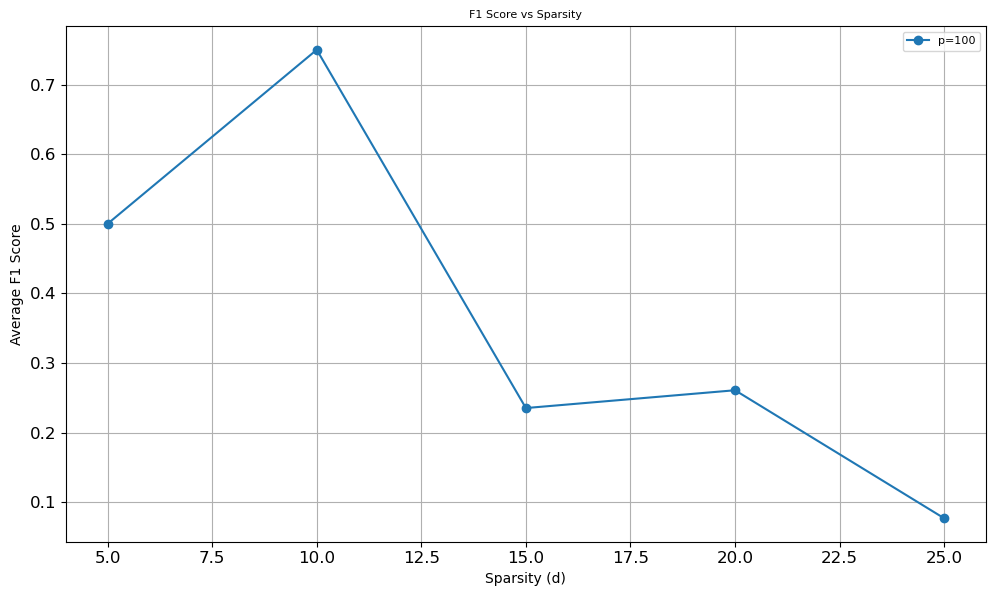

In [65]:
p_list = [100]
d_list = [5, 10, 15, 20, 25]
lambda_val = 0.05
rho_val = 2

f1_results = {p: [] for p in p_list}
np.random.seed(0)

for p in p_list:
    for d in d_list:
        args = SolverArgs(p=p, d=d, lambda_param=lambda_val, rho=rho_val, num_rep=1)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results[p].append(metrics['avg_f1'])

# Plotting
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(d_list, f1_results[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
f1_all = f1_results
f1_all

{25: [0.7499999999999999,
  0.18181818181818182,
  0.125,
  0.09523809523809523,
  0.07692307692307693],
 50: [0.888888888888889,
  0.8235294117647058,
  0.125,
  0.09523809523809523,
  0.07692307692307693]}

In [66]:
f1_all[100]=f1_results[100]
f1_all

{25: [0.7499999999999999,
  0.18181818181818182,
  0.125,
  0.09523809523809523,
  0.07692307692307693],
 50: [0.888888888888889,
  0.8235294117647058,
  0.125,
  0.09523809523809523,
  0.07692307692307693],
 75: [0.5714285714285715,
  0.33333333333333337,
  0.23529411764705882,
  0.09523809523809523,
  0.07692307692307693],
 100: [0.5,
  0.7499999999999999,
  0.23529411764705882,
  0.2608695652173913,
  0.07692307692307693]}

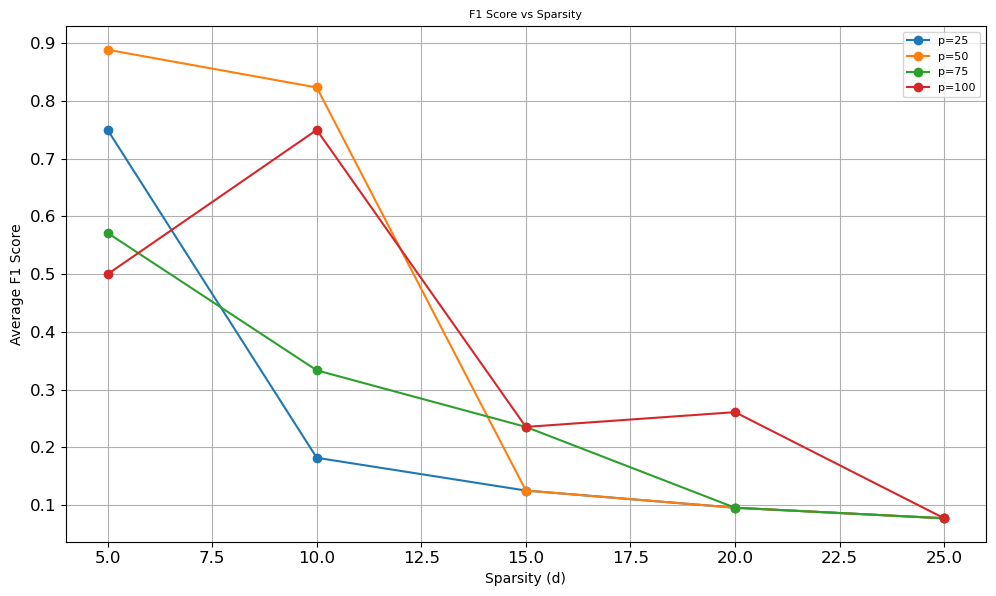

In [67]:
# Plotting
plt.figure(figsize=(10, 6))
for p in f1_all.keys():
    plt.plot(d_list, f1_all[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tau vs F1

Number of samples N: 39
Dimensions of Matrix =  50 Sparsity =  10
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search
999901.8659811597 [ 9.99804278e-01  1.17131681e-02  1.57243508e-03  1.03692723e-02
  3.90272131e-04 -2.88557219e-03  6.33875529e-03  2.18136343e-03
 -8.87824857e-04  1.23881501e-02  3.93380269e-03  3.34610551e-03
  3.06809475e-03  8.59349298e-03 -3.59604237e-04  2.75040693e-03
 -1.20056057e-03  9.09975481e-04  8.35828540e-03  1.38769469e-02
 -3.13600546e-03 -2.77579749e-03 -1.15523088e-03 -2.21764241e-03
 -2.80698909e-03  4.66391952e-03  5.03098566e-04 -1.72281505e-03
  6.95308367e-03  4.36854584e-03 -2.04329846e-04  4.11378688e-03
  2.44119483e-04  3.96793372e-04 -3.24485081e-04 -1.34550768e-03
 -1.58274699e-03 -1.97904285e-03 -1.83847510e-03 -8.25063869e-05


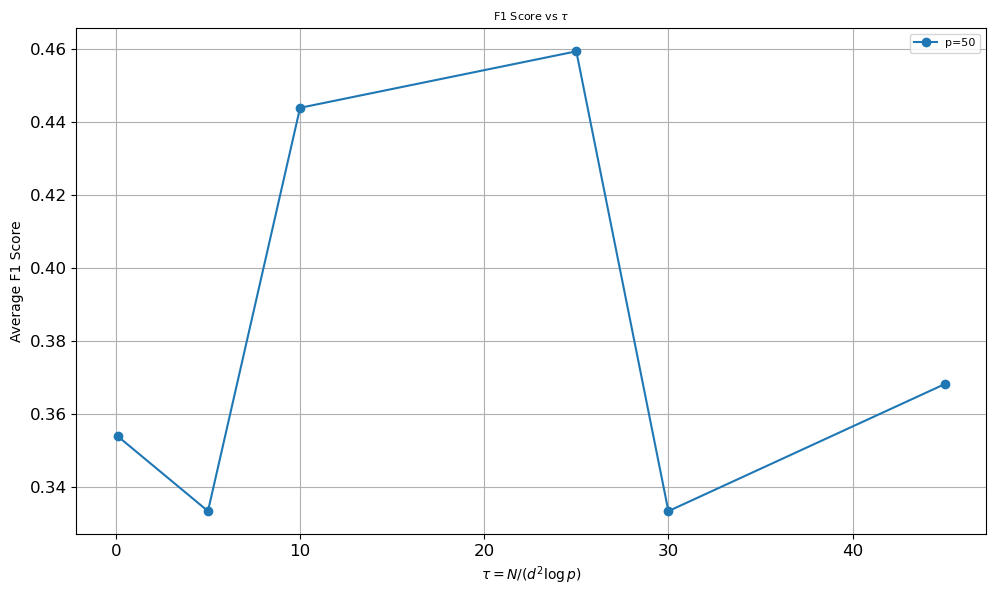

In [89]:
p_list = [50]
tau = [0.1, 5, 10, 25, 30, 45]
d_fixed = 10
lambda_val = 0.05
rho_val = 0.1
np.random.seed(0)

f1_results_ratio = {p: [] for p in p_list}

for p in p_list:
    for t in tau:
        args = SolverArgs(p=p, d=d_fixed, const=t, lambda_param=lambda_val, rho=rho_val, num_rep=2)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        f1_results_ratio[p].append(metrics['avg_f1'])

plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(tau, f1_results_ratio[p], marker='o', label=f'p={p}')

plt.xlabel(r"$\tau = N/(d^2 \log p)$")
plt.ylabel('Average F1 Score')
plt.title(r'F1 Score vs $\tau$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [82]:
f1_results_ratio

{25: [0.6086813186813187,
  0.8099206349206349,
  0.7452380952380954,
  0.7420634920634921,
  0.6269841269841269,
  0.8126984126984127]}